In [1]:
import pandas as pd
import mygene
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from modules.utils import select_exon

_Example:_ for mice experiments

In [ ]:
genes = ['CLK1', 'CLK2', 'CLK3', 'CLK4']

species = 'mouse'
assembly= "m10"

main_isoforms = {
    'CLK1': 'ENSMUST00000034868',
    'CLK2': 'ENSMUST00000121931',
    'CLK3': 'ENSMUST00000065330',
    'CLK4': 'ENSMUST00000093132'
}

gff_file = "/Users/antoninakuznetsova/Desktop/CLK/gencode.vM36.annotation.gff3" # Annotation file

path = Path('./pyIPSA_mice/').expanduser()
path_csv = path/'cassete_exons_mice.csv'

Get genes coordinates

In [4]:
mg = mygene.MyGeneInfo()
records = []

for gene in genes:
    gene_info = mg.query(gene, fields='genomic_pos', species=species, assembly=assembly, as_dataframe=True)

    if gene_info.empty:
        continue

    # Take first row
    row = gene_info.iloc[0].copy()

    # Handle the case if the field is empty and we need to extract it from a nested structure
    if pd.isna(row.get('genomic_pos.chr', None)):
        pos_data = row['genomic_pos'][0]
        for key in ['chr', 'start', 'end', 'ensemblgene', 'strand']:
            row[f'genomic_pos.{key}'] = pos_data.get(key)

    row['gene'] = gene
    records.append(row)

genes_coordinates = pd.DataFrame(records)
genes_coordinates.drop(columns=['genomic_pos'], errors='ignore', inplace=True)
genes_coordinates['genomic_pos.strand'] = genes_coordinates['genomic_pos.strand'].map({-1.0: '-', 1.0: '+'})
genes_coordinates['genomic_pos.chr'] = 'chr' + genes_coordinates['genomic_pos.chr'].astype(str)
genes_coordinates['genomic_pos.start'] = genes_coordinates['genomic_pos.start'].astype(int)
genes_coordinates['genomic_pos.end'] = genes_coordinates['genomic_pos.end'].astype(int)
genes_coordinates.rename(columns={'genomic_pos.chr': 'Chromosome'}, inplace=True)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Get cassete exons only for our genes

In [5]:
df_cassette_exons = pd.read_csv(path_csv).drop(columns=['start', 'end'])
df_cassette_exons.rename(columns={"start_exon": "Start", "end_exon": "End"}, inplace=True)

# If the species is mouse, substitute coordinates after liftover from another genome
if species == 'mouse':
    after_liftover = pd.read_csv(path / 'hglft_genome_1905d3_acfa80.bed', sep='\t', header=None, names=['chr', 's', 'e'])
    df_cassette_exons = (
        df_cassette_exons
        .reset_index(drop=True)
        .join(after_liftover)
        .drop(columns=['Start', 'End', 'chr'])
        .rename(columns={'s': 'Start', 'e': 'End'})
    )

columns_order = [
    'Start', 'End', 'ctrl_exclusion_count', 'ctrl_chx_exclusion_count',
    'ctrl_i1', 'ctrl_chx_i1', 'ctrl_i2', 'ctrl_chx_i2',
    'ctrl_psi', 'ctrl_chx_psi', 'chrom', 'strand'
]

df_cassette_exons = df_cassette_exons[columns_order]

Merge exon and gene data

In [6]:
cols = "Chromosome Start End Strand".split()
df_genes = genes_coordinates[['Chromosome', 'genomic_pos.start', 'genomic_pos.end', 'genomic_pos.strand']]
df_exons = df_cassette_exons[['chrom', 'Start', 'End', 'strand']]
df_genes.columns = cols
df_exons.columns = cols

# Create PyRanges objects for genes and exons
gr1, gr2 = pr.PyRanges(df_genes), pr.PyRanges(df_exons)
gr = gr1.intersect(gr2)

df_exons_genes = gr.df
df_exons_genes = df_exons_genes.merge(df_cassette_exons[df_cassette_exons.columns[:10]], how='left', on=['Start', 'End'])
df_exons_genes = df_exons_genes.merge(genes_coordinates[['gene', 'Chromosome']], how='right', on='Chromosome')

# Calculate the PSI difference between the ctrl and ctrl+chx experiments
df_exons_genes['dPSI'] = df_exons_genes['ctrl_psi'] - df_exons_genes['ctrl_chx_psi']

Extracting exons of major isoforms and their positions

In [8]:
df = pd.read_csv(gff_file, sep="\t", comment="#", header=None, 
                names=["chr", "source", "type", "start", "end", 
                        "score", "strand", "phase", "attributes"])

# Leave only the lines with exons
df_exons = df[df["type"] == "exon"]

df_exons_filtered = pd.DataFrame(columns=["chr", "source", "type", "start", "end", 
                        "score", "strand", "phase", "attributes", "gene", "exon_number"])
df_introns = pd.DataFrame(columns=["chr", "source", "type", "start", "end", 
                        "score", "strand", "phase", "attributes", "gene", "intron_number"])

# Go through the dictionary of major isoforms: key is gene_id, value is transcript_id
for key, value in main_isoforms.items():
    df_temp = df_exons[df_exons["attributes"].str.contains(f'transcript_id={value}')]
    df_temp['gene'] = key
    df_temp['exon_number'] = df_temp["attributes"].str.extract(r"exon_number=(\d+)")
    df_exons_filtered = pd.concat([df_exons_filtered, df_temp], ignore_index=True)
    
    df_temp.reset_index(drop=True, inplace=True)
    df1 = df_temp.copy()
    df2 = df_temp.copy()
    df1['my_index'] = df1.index
    df2['my_index'] = df2.index
    df2['my_index'] = df2['my_index'] - 1
    df_merged = df1.merge(df2[['start', 'end', 'my_index']], how='left', on='my_index')
    df_merged = df_merged.dropna(subset=['start_y', 'end_y'])
    df_merged.rename(columns={"start_y": "end", "end_x": "start"}, inplace=True)
    df_merged['intron_number'] = df_merged['exon_number'].astype(int) + 1
    del df_merged['start_x']
    del df_merged['end_y']
    del df_merged['exon_number']
    del df_merged['my_index']
    df_introns = pd.concat([df_introns, df_merged], ignore_index=True)

df_introns['end'] = df_introns['end'].astype(int)
df_introns['start'] = df_introns['start'].astype(int)
df_exons_filtered['end'] = df_exons_filtered['end'].astype(int)
df_exons_filtered['start'] = df_exons_filtered['start'].astype(int)

/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_5849/3341203634.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['gene'] = key
/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_5849/3341203634.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['exon_number'] = df_temp["attributes"].str.extract(r"exon_number=(\d+)")
/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_5849/3341203634.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or al

Merge tables

In [9]:
df_exons_genes = df_exons_genes.merge(df_exons_filtered[['start', 'end', 'exon_number']], how='left', right_on=['start', 'end'], left_on=['Start', 'End'])
del df_exons_genes['start']
del df_exons_genes['end']

Get intron intervals

In [10]:
intron_intervals = {}

for _, row in df_introns.iterrows():
    if row['gene'] not in intron_intervals:
        intron_intervals[row['gene']] = {}
    if row['strand'] == '-':
        intron_intervals[row['gene']][row['intron_number']] = [int(row['end']), int(row['start'])]    
    else:
        intron_intervals[row['gene']][row['intron_number']] = [int(row['start']), int(row['end'])]

Name exons in our cassete exons by intron intervals

In [11]:
df_exons_genes['exon_number'] = df_exons_genes.apply(lambda row: select_exon(row, intron_intervals), axis=1)

Visualise dPSI for interested genes

/var/folders/0z/f5_949pj6mv3z238ns_dy0cm0000gn/T/ipykernel_5849/357210975.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y="exon_number", x="dPSI", data=df_exons_genes_significant, hue="gene", ci=None, palette='pastel')


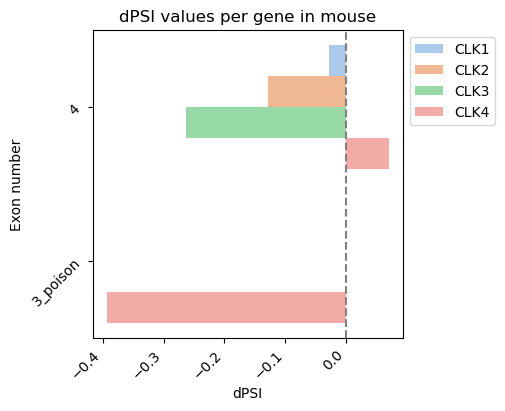

In [ ]:
df_exons_genes_significant = df_exons_genes[abs(df_exons_genes['dPSI']) > 0.01]

plt.figure(figsize=(4, 4))
sns.barplot(y="exon_number", x="dPSI", data=df_exons_genes_significant, hue="gene", ci=None, palette='pastel')

plt.ylabel("Exon number")
plt.xlabel("dPSI")
plt.axvline(x = 0, color = 'gray', linestyle='dashed')
plt.title(f"dPSI values per gene in {species}")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.savefig(path/'dPSI_mice.svg', bbox_inches='tight')

plt.show()